## 1. Importing Libraries

In [8]:
#Export as html
os.system('jupyter nbconvert --to html CA1_Part_A_CNN_with_PyTorch_92_Final.ipynb')

0

In [6]:
#Prevent duplicate libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
#Checking for GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#Check CPU and GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15380968564692914829
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11362561591970741802
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from torchvision import datasets
from torchvision import transforms
from torch import Tensor
from typing import Optional, List, Dict, Tuple
from torchvision.transforms import InterpolationMode
import torch.optim as optim
import time
from torchsummary import summary

In [5]:
#Environment setup for device and gpu
from torch import cuda, optim
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

device = torch.device("cuda:0" if train_on_gpu else "cpu")

multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


## 2. Visualizing Data

In [6]:
# Set random seed to be constant
torch.manual_seed(1)
np.random.seed(1)

In [7]:
cuda = False
batch_size = 96
#To prevent overloading, decently small batch size of 96

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [8]:
#Importing only training data to calculate mean and std
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), ]))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, **kwargs)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [9]:
#calculate mean and std of the train images for normalizing
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [10]:
print(mean, std)

tensor(0.2860) tensor(0.3202)


In [11]:
#Data augmentation to train the model with Randomly augmented images to improve training performance
#https://pytorch.org/vision/stable/_modules/torchvision/transforms/autoaugment.html#RandAugment
#Single channel taken from source code but changes for one channel grescale images
class OneChannelAugment(transforms.autoaugment.RandAugment):
    def __init__(   self, 
                    num_ops: int = 2, 
                    magnitude: int = 9, 
                    num_magnitude_bins: int = 31, 
                    is_single_channel: bool = True, 
                    interpolation: InterpolationMode = InterpolationMode.NEAREST, 
                    fill: Optional[List[float]] = None
                ) -> None:
        self.is_single_channel = is_single_channel
        super().__init__(num_ops=num_ops, magnitude=magnitude, num_magnitude_bins=num_magnitude_bins, interpolation=interpolation, fill=fill)
    
    def _augmentation_space(self, num_bins: int, image_size: List[int]) -> Dict[str, Tuple[Tensor, bool]]:
        if self.is_single_channel:
            return {
                #For greyscale
                "Identity": (torch.tensor(0.0), False),
                "ShearX": (torch.linspace(0.0, 0.3, num_bins), True),
                "ShearY": (torch.linspace(0.0, 0.3, num_bins), True),
                "TranslateX": (torch.linspace(0.0, 150.0 / 331.0 * image_size[0], num_bins), True),
                "TranslateY": (torch.linspace(0.0, 150.0 / 331.0 * image_size[1], num_bins), True),
                "Rotate": (torch.linspace(0.0, 30.0, num_bins), True),
                "Brightness": (torch.linspace(0.0, 0.9, num_bins), True),
            }
        else:
            return {
                #For RGB images
                "Identity": (torch.tensor(0.0), False),
                "ShearX": (torch.linspace(0.0, 0.3, num_bins), True),
                "ShearY": (torch.linspace(0.0, 0.3, num_bins), True),
                "TranslateX": (torch.linspace(0.0, 150.0 / 331.0 * image_size[0], num_bins), True),
                "TranslateY": (torch.linspace(0.0, 150.0 / 331.0 * image_size[1], num_bins), True),
                "Rotate": (torch.linspace(0.0, 30.0, num_bins), True),
                "Brightness": (torch.linspace(0.0, 0.9, num_bins), True),
                "Color": (torch.linspace(0.0, 0.9, num_bins), True),
                "Contrast": (torch.linspace(0.0, 0.9, num_bins), True),
                "Sharpness": (torch.linspace(0.0, 0.9, num_bins), True),
                "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 4)).round().int(), False),
                "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),
                "AutoContrast": (torch.tensor(0.0), False),
                "Equalize": (torch.tensor(0.0), False),
            }
                

In [12]:
#Augmenting images here
mean=0.2860
std=0.3202

transforms_train = transforms.Compose([
    transforms.Resize((80,80)),#Resizing images
    OneChannelAugment(magnitude = 20),#Calling image augmentation
    transforms.ToTensor(), 
    transforms.Normalize(mean, std),#Normalizing using values calculated above
])

transforms_test = transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std),
])

In [13]:
#Re-download both training and testing data with further transform, normalize, augment and size
train_data = datasets.FashionMNIST(
                            root='./data', 
                            train=True, 
                            download=False,
                            transform = transforms_train
                        )
test_data = datasets.FashionMNIST(
                            root='./data', 
                            train=False, 
                            download=True, 
                            transform = transforms_test
                        )

In [14]:
print(batch_size)

96


In [15]:
#Calculate train length and indexes to seperate loaders into train, val and test
train_length = train_data.__len__() 
train_indices = np.arange(train_length) 
np.random.shuffle(train_indices) 

# Create Data Loader
train_loader = DataLoader(
                        train_data, 
                        batch_size=batch_size, 
                        sampler = SubsetRandomSampler(train_indices[:int(train_length*0.8)]) # 80% of train data in train set
                    )

val_loader = DataLoader(
                        train_data, 
                        batch_size=batch_size, 
                        sampler = SubsetRandomSampler(train_indices[int(train_length*0.8):]) #20% of train data in validation set
                    )

test_loader = DataLoader( #All tst data
                        test_data, 
                        batch_size=batch_size,
                    )

# Disabling Data Augmentation on Validation Set
val_loader.dataset.transform = transforms_test
val_loader.dataset.transform

Compose(
    Resize(size=(80, 80), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=0.286, std=0.3202)
)

## Basic EDA

In [16]:
#Returning labels
def class_label(label):
    classes = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return classes[input]

In [17]:
#Basic EDA with labels for train_data
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 80, 80]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

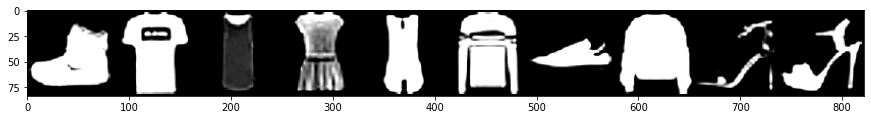

In [18]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(class_label(label), end=", ")

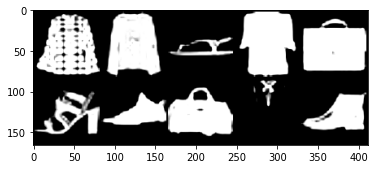

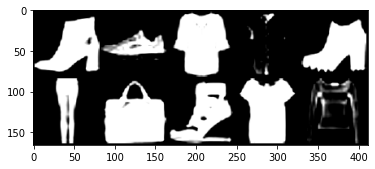

In [19]:
#Basic EDA Visualizations for train and val loader
training_batch = next(iter(train_loader))
validation_batch = next(iter(val_loader))

train_img = torchvision.utils.make_grid(training_batch[0][:10], nrow=5)
plt.imshow(train_img.permute(1,2,0))
plt.show()

validation_img = torchvision.utils.make_grid(validation_batch[0][:10], nrow=5)
plt.imshow(validation_img.permute(1,2,0))
plt.show()

## 3. Modeling

### implement models - vgg-16/19, resnet, efficient net, inception v3 

In [ ]:
#https://rwightman.github.io/pytorch-image-models/models/

In [ ]:
#Model E of technical Paper for VGG, VGG with 19 layers
#https://arxiv.org/pdf/1409.1556.pdf
#https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

<img src="https://iq.opengenus.org/content/images/2020/02/Screenshot-from-2020-02-22-16-32-43.png" alt="alt" width="50%"/>
<img src="https://miro.medium.com/max/980/1*vczqmHklozzgLpZxKAZEjw.jpeg" alt="alt" width="50%"/>


### VGG-16

In [ ]:
epoch = 10
learning_rate = 1e-4
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
#Initializing VGG-16 model
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        #making it 64 channels, not changing input layer size of 80*80, channels look for patterns
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        #[96, 1, 80, 80]
        x = F.relu(self.conv1_1(x))
        #[96, 64, 80, 80]
        x = F.relu(self.conv1_2(x))
        #[96, 64, 80, 80]
        x = self.maxpool(x)
        #[96, 64, 40, 40]
        x = F.relu(self.conv2_1(x))
        #[96, 128, 40, 40]
        x = F.relu(self.conv2_2(x))
        #[96, 128, 40, 40]
        x = self.maxpool(x)
        #[96, 128, 20, 20]
        x = F.relu(self.conv3_1(x))
        #[96, 256, 20, 20]
        x = F.relu(self.conv3_2(x))
        #[96, 256, 20, 20]
        x = F.relu(self.conv3_3(x))
        #[96, 256, 20, 20]
        x = self.maxpool(x)
        #[96, 256, 10, 10]
        x = F.relu(self.conv4_1(x))
        #[96, 512, 10, 10]
        x = F.relu(self.conv4_2(x))
        #[96, 512, 10, 10]
        x = F.relu(self.conv4_3(x))
        #[96, 512, 10, 10]
        x = self.maxpool(x)
        #[96, 512, 5, 5]
        x = F.relu(self.conv5_1(x))
        #[96, 512, 5, 5]
        x = F.relu(self.conv5_2(x))
        #[96, 512, 5, 5]
        x = F.relu(self.conv5_3(x))
        #[96, 512, 5, 5]
        x = self.maxpool(x)
        #[96, 512, 2, 2]
        #flatten at the end, to extract features
        x = x.reshape(x.shape[0], -1)
        #[96, 2048]
        x = F.relu(self.fc1(x))
        #increase accuracy, reduce overfitting, only changing 50% of neurons
        #[96, 4096]
        x = F.dropout(x, 0.5)
        #[96, 4096]
        x = F.relu(self.fc2(x))
        #[96, 4096]
        x = F.dropout(x, 0.5)
        #[96, 4096]
        x = self.fc3(x)
        #[96, 10]
        return F.log_softmax(x) #Log softmax is advantageous over softmax for improved numerical performance and gradient optimization.

In [ ]:
#Calling VGG-16 model for 10 epochs
model = VGG16().to(DEVICE)#set model weight to GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    num_correct=0
    num_samples=0
    startTime = time.time()
    train_loss=0.0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 67.88% Training Loss : 0.854536
Validation Epoch 1 ] Accuracy : 83.21%  Loss : 0.46772455096244814
Epoch 1 ] Time taken in seconds : 125.44307732582092
Training Epoch 2 ] Accuracy : 84.49% Training Loss : 0.417950
Validation Epoch 2 ] Accuracy : 86.23%  Loss : 0.36978736078739166
Epoch 2 ] Time taken in seconds : 124.36225366592407
Training Epoch 3 ] Accuracy : 87.41% Training Loss : 0.335734
Validation Epoch 3 ] Accuracy : 88.50%  Loss : 0.3098904219865799
Epoch 3 ] Time taken in seconds : 123.85826396942139
Training Epoch 4 ] Accuracy : 89.26% Training Loss : 0.289784
Validation Epoch 4 ] Accuracy : 88.94%  Loss : 0.30518676137924194
Epoch 4 ] Time taken in seconds : 124.1490433216095
Training Epoch 5 ] Accuracy : 90.48% Training Loss : 0.257199
Validation Epoch 5 ] Accuracy : 90.49%  Loss : 0.26209956568479537
Epoch 5 ] Time taken in seconds : 124.03076958656311
Training Epoch 6 ] Accuracy : 91.72% Training Loss : 0.226760
Validation Epoch 6 ] Accuracy 

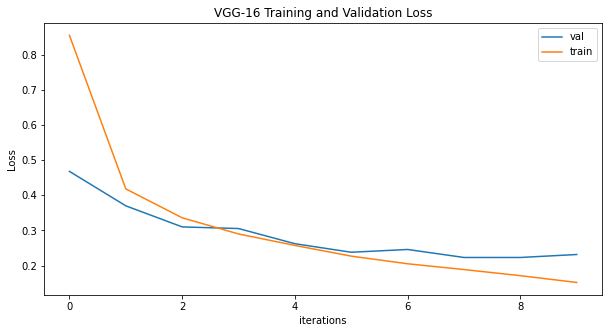

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-16 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

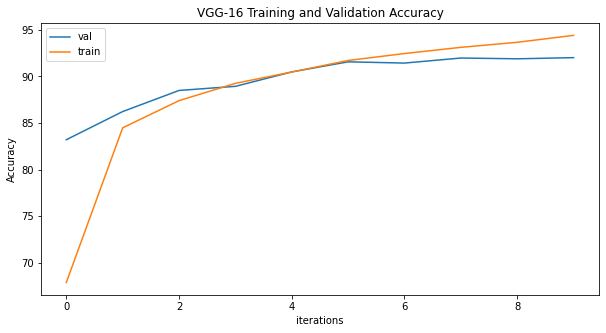

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-16 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 91.43%


In [ ]:
summary(model,input_size=(1,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]             640
            Conv2d-2           [-1, 64, 80, 80]          36,928
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 40, 40]          73,856
            Conv2d-5          [-1, 128, 40, 40]         147,584
         MaxPool2d-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
            Conv2d-8          [-1, 256, 20, 20]         590,080
            Conv2d-9          [-1, 256, 20, 20]         590,080
        MaxPool2d-10          [-1, 256, 10, 10]               0
           Conv2d-11          [-1, 512, 10, 10]       1,180,160
           Conv2d-12          [-1, 512, 10, 10]       2,359,808
           Conv2d-13          [-1, 512, 10, 10]       2,359,808
        MaxPool2d-14            [-1, 51

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### VGG-19

In [ ]:
#vgg-19
#Initializing VGG-16 model
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        #3_4 for VGG19
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #4_4 for VGG19
        self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #5_4 for VGG19
        self.conv5_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.relu(self.conv3_4(x))#vgg-19
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.relu(self.conv4_4(x))#vgg-19
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.relu(self.conv5_4(x))#vgg-19
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return F.log_softmax(x)

In [ ]:
#Calling VGG-19 model 
model = VGG19().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct = 0
    num_samples = 0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 59.66% Training Loss : 1.058646
Validation Epoch 1 ] Accuracy : 73.76%  Loss : 0.703732697725296
Epoch 1 ] Time taken in seconds : 145.35330176353455
Training Epoch 2 ] Accuracy : 81.59% Training Loss : 0.499700
Validation Epoch 2 ] Accuracy : 83.83%  Loss : 0.426372731924057
Epoch 2 ] Time taken in seconds : 144.1403501033783
Training Epoch 3 ] Accuracy : 86.12% Training Loss : 0.377481
Validation Epoch 3 ] Accuracy : 87.65%  Loss : 0.3438076723814011
Epoch 3 ] Time taken in seconds : 144.13716745376587
Training Epoch 4 ] Accuracy : 88.49% Training Loss : 0.318613
Validation Epoch 4 ] Accuracy : 88.25%  Loss : 0.3267471445798874
Epoch 4 ] Time taken in seconds : 144.03936004638672
Training Epoch 5 ] Accuracy : 89.67% Training Loss : 0.282681
Validation Epoch 5 ] Accuracy : 89.63%  Loss : 0.28831327497959136
Epoch 5 ] Time taken in seconds : 144.33961749076843
Training Epoch 6 ] Accuracy : 90.62% Training Loss : 0.255502
Validation Epoch 6 ] Accuracy : 90.

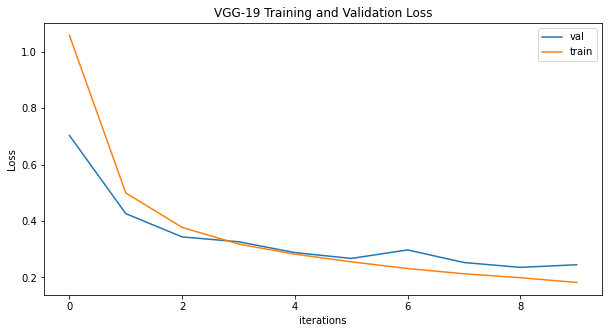

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-19 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

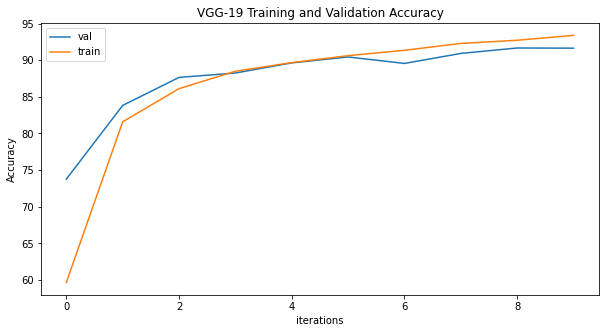

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-19 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 91.11%


In [ ]:
summary(model,input_size=(1,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]             640
            Conv2d-2           [-1, 64, 80, 80]          36,928
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 40, 40]          73,856
            Conv2d-5          [-1, 128, 40, 40]         147,584
         MaxPool2d-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
            Conv2d-8          [-1, 256, 20, 20]         590,080
            Conv2d-9          [-1, 256, 20, 20]         590,080
           Conv2d-10          [-1, 256, 20, 20]         590,080
        MaxPool2d-11          [-1, 256, 10, 10]               0
           Conv2d-12          [-1, 512, 10, 10]       1,180,160
           Conv2d-13          [-1, 512, 10, 10]       2,359,808
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## AlexNet
AlexNet was a deep neural network that was developed by Alex Krizhevsky and others in 2012. It was designed to classify images for the ImageNet [3] ILSVRC-2012 competition, where it achieved the state of the art results. It was introduced in the paper ImageNet Classification with Deep Convolutional Neural Networks

Alexnet starts with an input layer of 227 x 227 x 3 images , the next convolution layer consists of 96 (11 x 11) filters with a stride of 4. which reduces its dimension by 55 x 55. Followed by a MaxPool layer with 3 x 3 filter along with stride 2. This process goes on and finally reaches the Fully Connected layer with 9216 parameters and the next two Fully Connected layers with 4096 nodes each. In the end, it uses the Softmax function with 1000 output classes.. Alexnet is the first architecture to use ReLU non-linearity , Dropout for regularization and Multi-GPU training[3]
<img src="https://miro.medium.com/max/720/1*RT8gNyu608VSphZwLCoxIA.png" alt="alt" width="50%"/>




## AlexNet

In [ ]:
epoch = 10
learning_rate = 1e-4
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x)

In [ ]:
#Calling AlexNet model for 10 epochs
model = AlexNet().to(DEVICE)#set model weight to GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct = 0
    num_samples = 0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 72.36% Training Loss : 0.712063
Validation Epoch 1 ] Accuracy : 84.20%  Loss : 0.43736608147621153
Epoch 1 ] Time taken in seconds : 38.82448887825012
Training Epoch 2 ] Accuracy : 85.94% Training Loss : 0.384711
Validation Epoch 2 ] Accuracy : 87.08%  Loss : 0.3475809659957886
Epoch 2 ] Time taken in seconds : 36.2471489906311
Training Epoch 3 ] Accuracy : 88.66% Training Loss : 0.310723
Validation Epoch 3 ] Accuracy : 89.34%  Loss : 0.2946891413331032
Epoch 3 ] Time taken in seconds : 36.48926067352295
Training Epoch 4 ] Accuracy : 90.19% Training Loss : 0.269933
Validation Epoch 4 ] Accuracy : 90.18%  Loss : 0.2745768982172012
Epoch 4 ] Time taken in seconds : 36.2762553691864
Training Epoch 5 ] Accuracy : 91.28% Training Loss : 0.241118
Validation Epoch 5 ] Accuracy : 90.38%  Loss : 0.27057966125011446
Epoch 5 ] Time taken in seconds : 36.006195306777954
Training Epoch 6 ] Accuracy : 92.18% Training Loss : 0.216201
Validation Epoch 6 ] Accuracy : 90.77

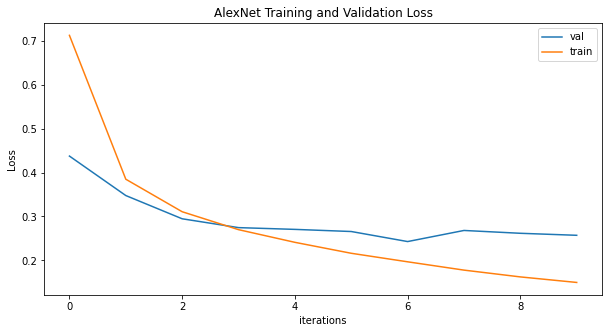

In [ ]:
plt.figure(figsize=(10,5))
plt.title("AlexNet Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

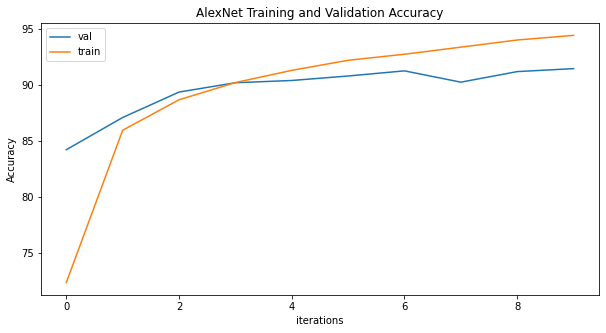

In [ ]:
plt.figure(figsize=(10,5))
plt.title("AlexNet Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 91.07%


In [ ]:
summary(model,input_size=(1,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 19, 19]           7,808
              ReLU-2           [-1, 64, 19, 19]               0
 LocalResponseNorm-3           [-1, 64, 19, 19]               0
         MaxPool2d-4             [-1, 64, 9, 9]               0
            Conv2d-5            [-1, 192, 9, 9]         307,392
              ReLU-6            [-1, 192, 9, 9]               0
         MaxPool2d-7            [-1, 192, 4, 4]               0
            Conv2d-8            [-1, 384, 4, 4]         663,936
              ReLU-9            [-1, 384, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         884,992
             ReLU-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 256, 4, 4]         590,080
             ReLU-13            [-1, 256, 4, 4]               0
        MaxPool2d-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## ResNet
ResNet was a real deeper architecture which has 152 layers. It was introduced in the paper “Deep Residual Learning for Image Recognition” it won the Imagenet 2015 competition, ever since most of the CNNsare variants of these Resnets. It became so popular since it avoids the vanishing gradient problem, that is when creating deeper nets mostly loss of the network increased after a certain point both in train and test sets, to avoid this major problem, the authors proposed to use a reference to the previous layer [5] to compute the output at a given layer. In ResNet, the output from the previous layer, which is called residual, is added to the output of the current layer.
<img src="https://miro.medium.com/max/1100/1*66l48ybZsnQxWLWc_qOZ1w.jpeg" alt="alt" width="150%"/>
<img src="https://miro.medium.com/max/1100/0*79p7WhWeMd54YRYr.png" alt="alt" width="150%"/>

In [ ]:
epoch = 10
learning_rate = 1e-4
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
# an essential block of layers which forms resnets
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        #shortcut downsampling with stride 2
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
            #downsampling with stride 1
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()
        
        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:

class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=1000):
        super().__init__()
        #Layer0 consists of a 7*7 convolution and a 3*3 max pooling
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,), resblock(filters[4], filters[4], downsample=False))

        #Final layer uses global average pooling gap and a fully connected layer, GAP calculates mean of each feature map and then concatenates all the values into a one-dimension list.
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return F.log_softmax(input)

In [ ]:
#Calling ResNet18 model for 10 epochs
#1 image channel, 10 output classes
model = ResNet(1, ResBlock, [2,2,2,2], useBottleneck=False, outputs=10).to(DEVICE)#set model weight to GPU
# #ResNet34
# model = ResNet(1, ResBlock, [3,4,6,3], useBottleneck=False, outputs=10).to(DEVICE)
# #ResNet50
# model = ResNet(1, ResBottleneckBlock, [3,4,6,3], useBottleneck=True, outputs=10).to(DEVICE)
# #ResNet101
# model = ResNet(1, ResBottleneckBlock, [3,4,23,3], useBottleneck=True, outputs=10).to(DEVICE)
# #ResNet152
# model = ResNet(1, ResBottleneckBlock, [3,8,63,3], useBottleneck=True, outputs=10).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss += loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 86.68% Training Loss : 0.370817
Validation Epoch 1 ] Accuracy : 90.50%  Loss : 0.26792272156476976
Epoch 1 ] Time taken in seconds : 44.51798748970032
Training Epoch 2 ] Accuracy : 91.74% Training Loss : 0.224426
Validation Epoch 2 ] Accuracy : 91.73%  Loss : 0.23189877188205718
Epoch 2 ] Time taken in seconds : 42.93033719062805
Training Epoch 3 ] Accuracy : 93.49% Training Loss : 0.175276
Validation Epoch 3 ] Accuracy : 90.75%  Loss : 0.25957626396417616
Epoch 3 ] Time taken in seconds : 42.94174027442932
Training Epoch 4 ] Accuracy : 95.04% Training Loss : 0.134400
Validation Epoch 4 ] Accuracy : 91.43%  Loss : 0.250556756734848
Epoch 4 ] Time taken in seconds : 42.98606729507446
Training Epoch 5 ] Accuracy : 96.13% Training Loss : 0.104851
Validation Epoch 5 ] Accuracy : 91.34%  Loss : 0.26967595958709717
Epoch 5 ] Time taken in seconds : 43.01645588874817
Training Epoch 6 ] Accuracy : 97.02% Training Loss : 0.082329
Validation Epoch 6 ] Accuracy : 91.

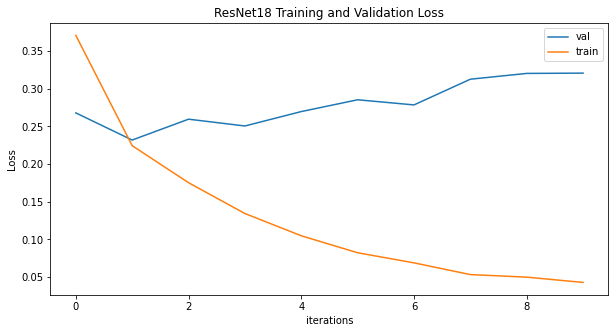

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet18 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

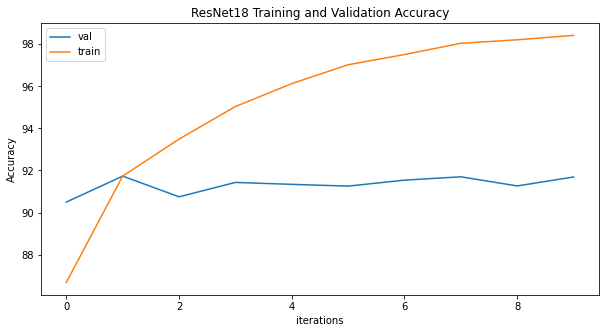

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet18 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 91.21%


In [ ]:
summary(model,input_size=(1,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]           3,200
         MaxPool2d-2           [-1, 64, 20, 20]               0
       BatchNorm2d-3           [-1, 64, 20, 20]             128
              ReLU-4           [-1, 64, 20, 20]               0
            Conv2d-5           [-1, 64, 20, 20]          36,928
       BatchNorm2d-6           [-1, 64, 20, 20]             128
            Conv2d-7           [-1, 64, 20, 20]          36,928
       BatchNorm2d-8           [-1, 64, 20, 20]             128
          ResBlock-9           [-1, 64, 20, 20]               0
           Conv2d-10           [-1, 64, 20, 20]          36,928
      BatchNorm2d-11           [-1, 64, 20, 20]             128
           Conv2d-12           [-1, 64, 20, 20]          36,928
      BatchNorm2d-13           [-1, 64, 20, 20]             128
         ResBlock-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
#Calling ResNet152 model for 10 epochs
#1 image channel, 10 output classes
#model = ResNet(1, ResBlock, [2,2,2,2], useBottleneck=False, outputs=10).to(DEVICE)#set model weight to GPU
# #ResNet34
# model = ResNet(1, ResBlock, [3,4,6,3], useBottleneck=False, outputs=10).to(DEVICE)
# #ResNet50
# model = ResNet(1, ResBottleneckBlock, [3,4,6,3], useBottleneck=True, outputs=10).to(DEVICE)
# #ResNet101
# model = ResNet(1, ResBottleneckBlock, [3,4,23,3], useBottleneck=True, outputs=10).to(DEVICE)
# #ResNet152
model = ResNet(1, ResBottleneckBlock, [3,8,63,3], useBottleneck=True, outputs=10).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 76.68% Training Loss : 0.652797
Validation Epoch 1 ] Accuracy : 86.32%  Loss : 0.3833806518316269
Epoch 1 ] Time taken in seconds : 365.0293138027191
Training Epoch 2 ] Accuracy : 87.74% Training Loss : 0.333308
Validation Epoch 2 ] Accuracy : 87.94%  Loss : 0.3370537688732147
Epoch 2 ] Time taken in seconds : 355.4191415309906
Training Epoch 3 ] Accuracy : 90.49% Training Loss : 0.265633
Validation Epoch 3 ] Accuracy : 90.37%  Loss : 0.2715785890221596
Epoch 3 ] Time taken in seconds : 355.82997822761536
Training Epoch 4 ] Accuracy : 91.96% Training Loss : 0.216842
Validation Epoch 4 ] Accuracy : 90.12%  Loss : 0.27462056356668474
Epoch 4 ] Time taken in seconds : 355.33411717414856
Training Epoch 5 ] Accuracy : 93.25% Training Loss : 0.185031
Validation Epoch 5 ] Accuracy : 90.27%  Loss : 0.2780293313860893
Epoch 5 ] Time taken in seconds : 355.7592976093292
Training Epoch 6 ] Accuracy : 93.82% Training Loss : 0.166583
Validation Epoch 6 ] Accuracy : 88.

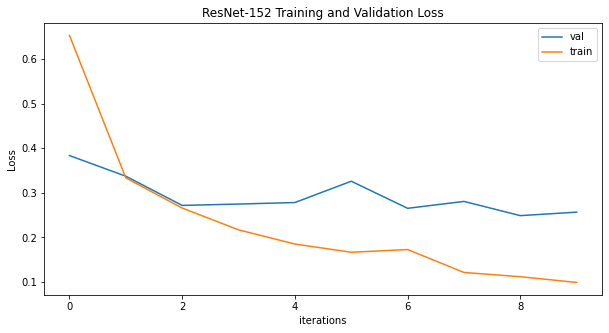

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet-152 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

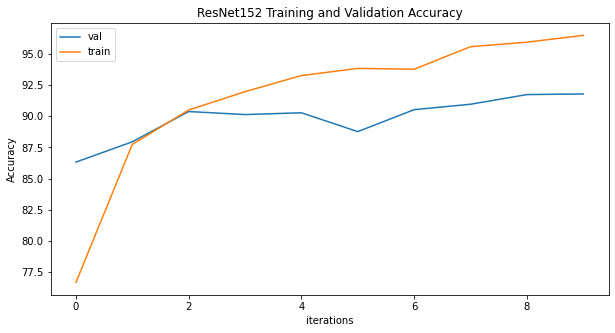

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet152 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 91.22%


In [ ]:
summary(model,input_size=(1,80,80)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]           3,200
         MaxPool2d-2           [-1, 64, 20, 20]               0
       BatchNorm2d-3           [-1, 64, 20, 20]             128
              ReLU-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 256, 20, 20]          16,640
       BatchNorm2d-6          [-1, 256, 20, 20]             512
            Conv2d-7           [-1, 64, 20, 20]           4,160
       BatchNorm2d-8           [-1, 64, 20, 20]             128
            Conv2d-9           [-1, 64, 20, 20]          36,928
      BatchNorm2d-10           [-1, 64, 20, 20]             128
           Conv2d-11          [-1, 256, 20, 20]          16,640
      BatchNorm2d-12          [-1, 256, 20, 20]             512
ResBottleneckBlock-13          [-1, 256, 20, 20]               0
           Conv2d-14           [-1, 64

<h2>Part A Fashion MNIST Model Comparisons at baseline 10 epochs</h2>
<table>
<thead><tr><th>Model</th><th>Training Loss</th><th>Training Accuracy</th><th>Validation Loss</th><th>Validation Accuracy</th><th>Test Accuracy</th><th>Total Training Time</th><th>Total Parameters</th><th>Remarks</th></tr></thead>
<tbody>
<tr><td>VGG-16</td><td>0.15</td><td>94.42%</td><td>0.23</td><td>92.03%</td><td>91.43%</td><td>21 Mins</td><td>39.9Million</td><td>High accuracy scores and stable downwards trend for loss and upwards trend for accuracy, no signs of overfitting</td></tr>
<tr><td>VGG-19</td><td>0.18</td><td>93.39%</td><td>0.24</td><td>91.64%</td><td>91.11%</td><td>24 Mins</td><td>45.2Million</td><td>Slightly lower accuracy than VGG-16 but similar performance</td></tr>
<tr><td>AlexNet</td><td>0.15</td><td>94.4%</td><td>0.26</td><td>91.43%</td><td>91.07%</td><td>6 Mins</td><td>57Million</td><td>Lower Test and Validation accuracy scores, clear signs of overfitting</td></tr>
<tr><td>ResNet18</td><td>0.04</td><td>98.42%</td><td>0.32</td><td>91.69%</td><td>91.21%</td><td>7 Mins</td><td>11.2Million</td><td>Very clear signs of overfitting and low accuracy scores, trend for validation is also poor with no signs of downawards trend</td></tr>
<tr><td>ResNet152</td><td>0.09</td><td>96.47%</td><td>0.25</td><td>91.77%</td><td>91.22%</td><td>1 Hour</td><td>16.8Million</td><td>Better trend in loss than ResNet18 but still signs of overfitting</td></tr>
</tbody>
</table>

## My Own Model
With Inspiration from the previous models, we can see the analysis below:

VGGNet
1. VGG-16 and VGG-19, VGG-16 performed better with lower epochs of 10, it is expected to beat VGG-19 if the epochs were higher. However, in the techical paper, VGG-16 was preferred as it is less computationally expensive with not much difference in loss function and accuracy performance as comapared to the VGG-19, Our VGG-16 performed 91.79 % accuracy on the test Set

AlexNet
2. AlexNet, AlexNet achieved a accuracy score of 90.64%, the AlexNet performed poorer as compared to VGG-16 and the Validation and Training curves comparing Accuracy and Loss function for the AlexNet were significantly worse compared to the VGG ones, for VGG the curves would converge while for the AlexNet, the curves did not converge in fact the loss function got significantly worse in the validation set.

ResNet

3.ResNet18 and ResNet152 achieved a accuracy score of 91.42 and 90,43 respectively. However, both ResNet18 and ResNet 152 loss and accuracy curve comparison for training and validation did not converge. Overall ResNet also achieved a poorer performance in both score and graphs as compared to VGG-16


My Own model shall consist of elements inspired from the better performing models in these experiments, such as the VGG16. I will be creating my own model architecture inspired by these architectural experiments back in 2013-2015, why not after 2016? the models which are SOTA after 2016 such as EfficientNet and InceptionV3 were my initial choices. However this module's purpose is to design a model architecure from scratch and not import pretrained and prebuilt architectures. Architectures like the Inception v3 are exceptionally large and is extremely inefficient to built from scratch, Thus, i will be crafting my own inspired model architecture which will hopefully achieve a good level of performance.

My first custom model will be a VGG inspired model

The experimental tweaks i did are listed below:
1. I reduced the number of convolutional 2d layers to reduce complexity 
2. I added Batch Normalization as it has a regularizing effect on CNN by normalizing inputs to layers deeper into a network
4. I did global average pooling's pytorch version of adaptive avg pool, Global pooling helps prevent overfitting whereas VGG only used max pooling
5. Dropout, since i wanted to reduce overfitting a dropout was added before the final classification 

In [ ]:
epoch = 10
learning_rate = 1e-4
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
#Initializing VGG-16 model
class MyCustomNet(nn.Module):
    def __init__(self):
        super(MyCustomNet, self).__init__()

        #Custom inspired VGG
        self.vgglayer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),#self.conv1_1
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
        )
        self.vgglayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
        )
        
        self.vgglayer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
           # nn.BatchNorm2d(256),
        )
        self.vgglayer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        self.vgglayer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        #Pooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        #Final Layer
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.vgglayer1(x)
        x = self.maxpool(x)
        x = self.vgglayer2(x)
        x = self.maxpool(x)
        x = self.vgglayer3(x)
        x = self.maxpool(x)
        x = self.vgglayer4(x)
        x = self.maxpool(x)
        x = self.vgglayer5(x)      
        x = self.avgpool(x)#Replace max with avg
        #flatten at the end, to extract features
        # x = x.reshape(x.shape[0], -1)
        x=torch.flatten(x,1)#Replace resahpe with flatten
        x=self.classifier(x)
        return F.log_softmax(x) #Log softmax is advantageous over softmax for improved numerical performance and gradient optimization.

In [ ]:
model = MyCustomNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 78.54% Training Loss : 0.572587
Validation Epoch 1 ] Accuracy : 86.51%  Loss : 0.35545768463611604
Epoch 1 ] Time taken in seconds : 150.3177993297577
Training Epoch 2 ] Accuracy : 87.85% Training Loss : 0.325801
Validation Epoch 2 ] Accuracy : 88.98%  Loss : 0.30338077330589297
Epoch 2 ] Time taken in seconds : 149.6496012210846
Training Epoch 3 ] Accuracy : 90.06% Training Loss : 0.266446
Validation Epoch 3 ] Accuracy : 89.50%  Loss : 0.28628071093559265
Epoch 3 ] Time taken in seconds : 149.99603724479675
Training Epoch 4 ] Accuracy : 91.39% Training Loss : 0.234970
Validation Epoch 4 ] Accuracy : 91.24%  Loss : 0.24146041303873061
Epoch 4 ] Time taken in seconds : 149.50725173950195
Training Epoch 5 ] Accuracy : 92.26% Training Loss : 0.206858
Validation Epoch 5 ] Accuracy : 91.38%  Loss : 0.23790082758665085
Epoch 5 ] Time taken in seconds : 149.66577529907227
Training Epoch 6 ] Accuracy : 93.06% Training Loss : 0.187230
Validation Epoch 6 ] Accuracy 

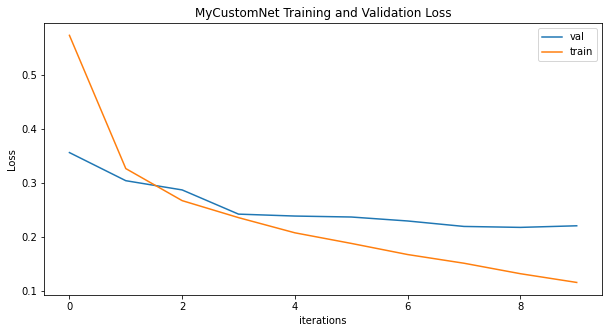

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

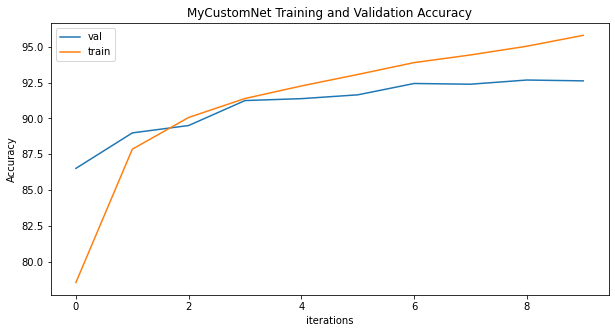

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 92.33%


In [ ]:
summary(model,input_size=(1,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]             640
              ReLU-2           [-1, 64, 80, 80]               0
            Conv2d-3           [-1, 64, 80, 80]          36,928
              ReLU-4           [-1, 64, 80, 80]               0
         MaxPool2d-5           [-1, 64, 40, 40]               0
            Conv2d-6          [-1, 128, 40, 40]          73,856
              ReLU-7          [-1, 128, 40, 40]               0
            Conv2d-8          [-1, 128, 40, 40]         147,584
              ReLU-9          [-1, 128, 40, 40]               0
        MaxPool2d-10          [-1, 128, 20, 20]               0
           Conv2d-11          [-1, 256, 20, 20]         295,168
             ReLU-12          [-1, 256, 20, 20]               0
           Conv2d-13          [-1, 256, 20, 20]         590,080
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## 4. Hyperparameter Tuning
1. Learning Rate I used a Learning rate schedular which decreases learning rate by 1/10th if epoch's avg loss function doesn't decrease after 5 epochs.
2. Number of Epochs, I increased the number of epochs to 50 for Part A but epochs dont matter due to early stopping
3. Optimiser I tried 2 different optimisers SGD and Adam, SGD Showed a better and more stable loss trend, this is likely because Adam optimizers affect learning rate
4. Loss Function, I tried CrossEntropyLoss and NLLLoss, Cross Entropy had a better and quicker loss curve performance
5. Momentum (closely related to Learning Rate)
6. Weight decay, the higher the value, the more it prevents overfitting, Momentum is L2 regularization
(small value to decrease regularization, large value to increase regularization but may cause instability)
7. Batch Size (small for more regularization, large for less regularization)

I decided to tune the final model as my custom model which achieved better accuracy of 92.33% than the VGG-16 which achieved 91.43%, this shows that my custom model was better.

<h2>Hyper-parameter settings 
<table>
<thead><tr><th>Hyper-parameters</th><th>Description</th></tr></thead>
<tbody>
<tr><td>lr=1e-4</td><td>Learning Rate with Early Stopping</td></tr>
<tr><td>momentum=0.9</td><td>Momentum Factor</td></tr>
<tr><td>weight_decay=1e-5</td><td>Weight decay for L2 Penalty</td></tr>
<tr><td>epochs=50</td><td>Number of epochs to train</td></tr>
<tr><td>batch_size=96</td><td>Batch size to prevent overloading</td></tr>
<tr><td>Learning Rate scheduler: ReduceLROnPlateu</td><td>LR scheduler reduces lr based on validation loss metric</td></tr>
<tr><td>Loss Function: Cross Entropy Loss</td><td>Loss Function</td></tr>
<tr><td>Optimiser: SGD</td><td>Optimizer between Adam and SGD</td></tr>
</tbody>
</table>

<table>
<thead><tr>><th>Learning Rate Scheduler</th></tr></thead>
<tbody>
<tr><td>LambdaLR (Sets the learning rate of each parameter group to the initial lr times a given function. When last_epoch=-1, sets initial lr as lr.)</td></tr>
<tr><td>MultiplicativeLR (#works the same but multiplies the lr of each parameter group by the factor given in specified function, so it gets lower)</td></tr>
<tr><td>StepLR (It decays lr of each parameter grp by gamma every step size epochs)</td></tr>
<tr><td>MultiStepLR (It decays lr of each parameter grp by gamma every milestone)</td></tr>
<tr><td>ReduceLROnPlateu (Instead of reducing learning rate based on epochs, it reduces lr when a metric has stopped improving, metric used here will be validation loss)</td></tr>
</tbody>
</table>

In [20]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [21]:
#Initializing VGG-16 model
class MyCustomNet(nn.Module):
    def __init__(self):
        super(MyCustomNet, self).__init__()

        #Custom inspired VGG
        self.vgglayer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),#self.conv1_1
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
        )
        self.vgglayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
        )
        
        self.vgglayer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
           # nn.BatchNorm2d(256),
        )
        self.vgglayer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        self.vgglayer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        #Pooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        #Final Layer
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.vgglayer1(x)
        x = self.maxpool(x)
        x = self.vgglayer2(x)
        x = self.maxpool(x)
        x = self.vgglayer3(x)
        x = self.maxpool(x)
        x = self.vgglayer4(x)
        x = self.maxpool(x)
        x = self.vgglayer5(x)      
        x = self.avgpool(x)#Replace max with avg
        #flatten at the end, to extract features
        # x = x.reshape(x.shape[0], -1)
        x=torch.flatten(x,1)#Replace resahpe with flatten
        x=self.classifier(x)
        return F.log_softmax(x) #Log softmax is advantageous over softmax for improved numerical performance and gradient optimization.

In [22]:
epoch=50#Max no. of epochs
model = MyCustomNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#Adam already handles learning rate optimization
#optimizer = optim.Adam(model.parameters(), lr= learning_rate, weight_decay=weight_decay)#Signs of overfitting, trg 99.17, val 91.67, Conclusion 1e-5 weight decay needs to be higher
#optimizer = optim.SGD(model.parameters(), lr= learning_rate, weight_decay=1e-3, momentum=0.9)#Learning rate too slow
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-4, weight_decay=1e-5, nesterov=True, momentum=0.9)
#Weight decay for L2 regularization

#learning rate scheduler
#Learning rate increases depending on epoch, epoch 1 is 0.1 lr, epoch 10 is 1 lr
#lambda1 = lambda e: e/10
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1)#Sets the learning rate of each parameter group to the initial lr times a given function. When last_epoch=-1, sets initial lr as lr.

#works the same but multiplies the lr of each parameter group by the factor given in specified function, so it gets lower
#lambda2 = lambda e:0.95
#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda2)

#It decays lr of each parameter grp by gamma every step size epochs
#Every 15 epochs it decays by half
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

#It decays lr of each parameter grp by gamma every milestone
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30], gamma=0.8)

#Instead of reducing learning rate based on epochs, it reduces lr when a metric has stopped improving
#Scheduler reads a metrics quantity and if no improvement is seen for a 'patience' number of epochs, lr is reduced
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
#Min mode to reduce when quantity monitored stopped, reduce by factor of 2-10 has shown improvements, patience if 4th epoch shows no improvement, decrease

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Early stop variables
n_epochs_stop = 4
epochs_no_improve = 0
early_stop = False
min_val_loss=1

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
        #Early stopping
        if (valid_loss/len(val_loader)) < min_val_loss:
            epochs_no_improve=0
            min_val_loss=(valid_loss/len(val_loader))
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_loss:{min_val_loss}')
        else:
            epochs_no_improve+=1
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
    
        if e>5 and epochs_no_improve==n_epochs_stop:
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            early_stop=True
    
    #Learning rate scheduler
    scheduler.step(valid_loss/len(val_loader))
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')
    #Check early stopping condition
    if early_stop:
      print("Early Stopping")
      break
    

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 44.63% Training Loss : 1.717139
Validation Epoch 1 ] Accuracy : 66.95%  Loss : 0.9904772882461548
Epoch 1 ] Time taken in seconds : 149.77014756202698
Training Epoch 2 ] Accuracy : 72.81% Training Loss : 0.780903
Validation Epoch 2 ] Accuracy : 75.70%  Loss : 0.6692897095680237
Epoch 2 ] Time taken in seconds : 143.34542107582092
Training Epoch 3 ] Accuracy : 77.57% Training Loss : 0.607387
Validation Epoch 3 ] Accuracy : 78.77%  Loss : 0.5664192898273468
Epoch 3 ] Time taken in seconds : 142.75638461112976
Training Epoch 4 ] Accuracy : 80.49% Training Loss : 0.529203
Validation Epoch 4 ] Accuracy : 81.44%  Loss : 0.5060404603481292
Epoch 4 ] Time taken in seconds : 143.08200764656067
Training Epoch 5 ] Accuracy : 82.71% Training Loss : 0.471611
Validation Epoch 5 ] Accuracy : 83.29%  Loss : 0.4572698621749878
Epoch 5 ] Time taken in seconds : 143.12289452552795
Training Epoch 6 ] Accuracy : 84.42% Training Loss : 0.426701
Validation Epoch 6 ] Accuracy : 8

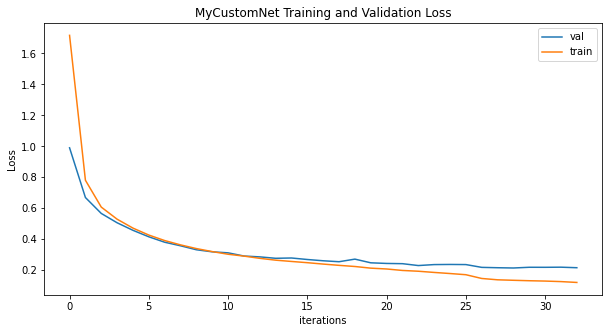

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

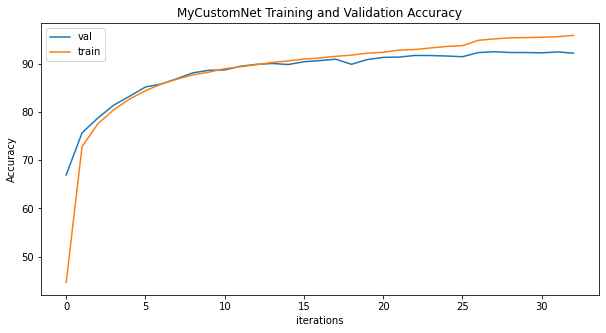

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy of network on 10000 images in test_loader: {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of network on 10000 images in test_loader: 92.06%


In [24]:
#Save the model
torch.save(model, 'MyCustomNetMNIST.pt')

In [ ]:
#Load model
# Model class must be defined somewhere
model = torch.load('MyCustomNetMNIST.pt')

##5. Final Model 91.42% Accuracy with good loss curve and accuracy curves

In [25]:
# Class names
Classes = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


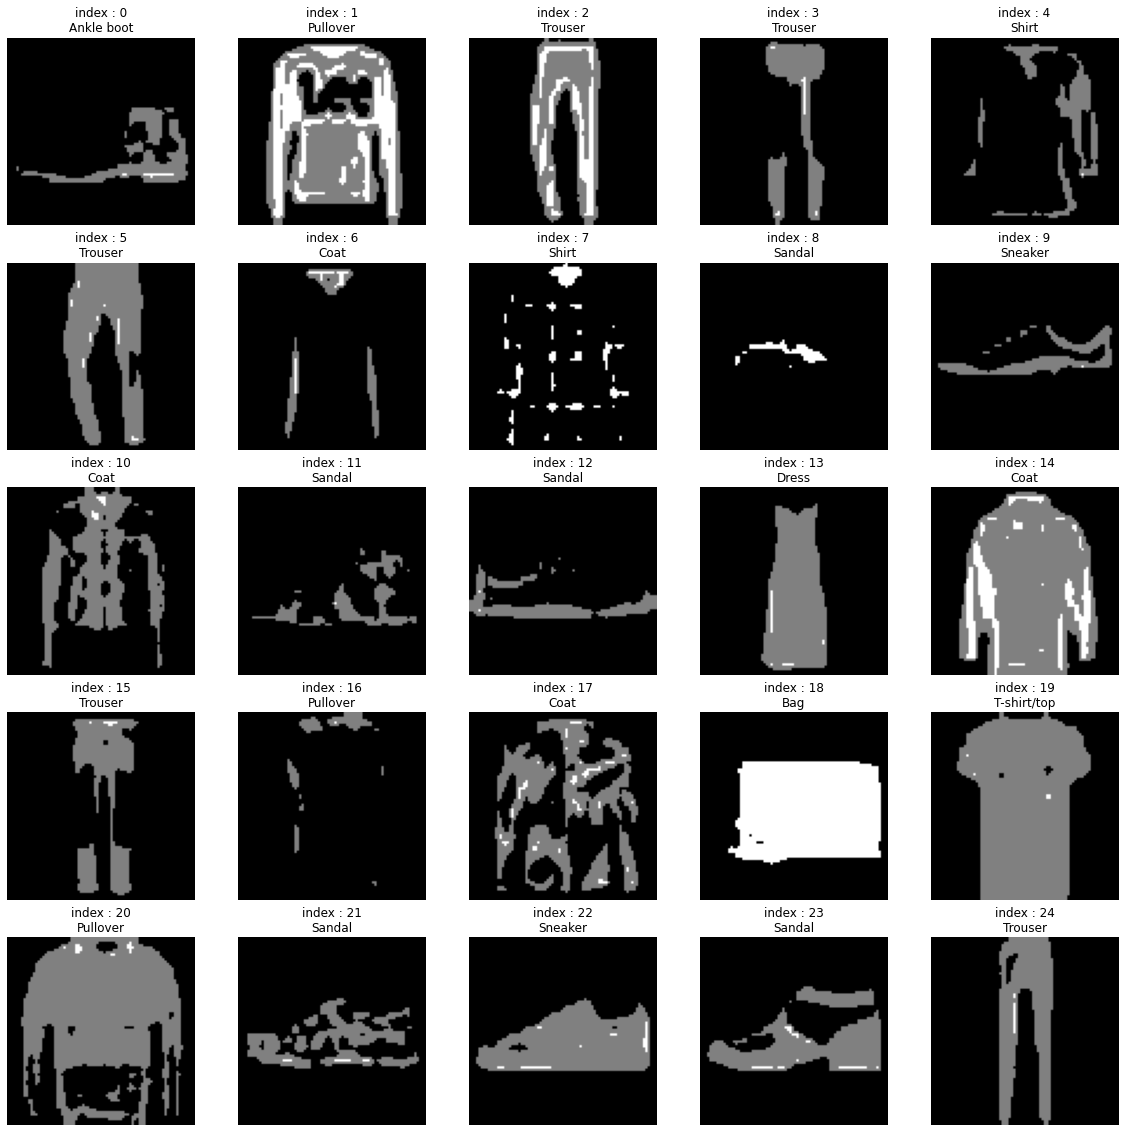

In [ ]:
#Evaluating images in test_loader
test_images = iter(test_loader)
plt.figure(figsize=(20, 20)) 
data, target= next(test_images) 
image = data.to(DEVICE)
labels = target.to(DEVICE)

model.eval() 
predictions = model(image) 
y_pred = torch.argmax(predictions, dim=1).to(DEVICE) 

for i in range(25):
  ax = plt.subplot(5, 5, i + 1) 
  plt.imshow(data[i].permute(1,2,0).numpy().reshape((80,80)).astype("uint8"), cmap = 'gray')
  current_index = i
  plt.title(f"index : {current_index}\n{Classes[int(y_pred[current_index:current_index+1])]}")
  plt.axis("off")

Getting predictions from test set...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


<Figure size 1440x1440 with 0 Axes>

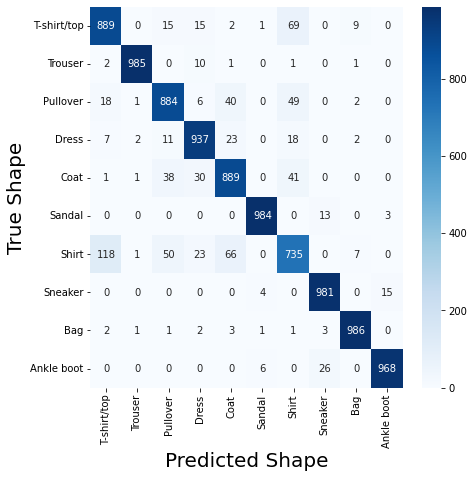

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
# Defining Labels and Predictions
test_images = iter(test_loader)
plt.figure(figsize=(20, 20)) # Set figure size 
data, target= next(test_images) # get the images from the test images that we iterate over
image = data.to(device)
labels = target.to(device)
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model(data).cpu().data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(Classes))

df_cm = pd.DataFrame(cm, index = Classes, columns = Classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()